In [20]:
import cv2
import mediapipe as mp
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
video_path = './Data/videos/20240301_173556.mp4'
output_csv = './output'

In [3]:
## initialize pose estimator
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.1, min_tracking_confidence=0.2, model_complexity = 2)

In [75]:
cap = cv2.VideoCapture(video_path)
res = []
while cap.isOpened():
    # read frame
    _, frame = cap.read()
    try:
         # resize the frame for portrait video
         frame = frame#[0:1440,3840-2560:3840]
         #frame = cv2.resize(frame, (1280, 720))
         # convert to RGB
         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
         
         # process the frame for pose detection
         pose_results = pose.process(frame_rgb)
         # print(pose_results.pose_landmarks)
         res.append(pose_results)
         
         # draw skeleton on the frame
         mp_drawing.draw_landmarks(frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
         # display the frame
         cv2.imshow('Output', cv2.resize(frame, (1280, 720)))
    except:
         break
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) #wait until any key is pressed
    
    
          
cap.release()
cv2.destroyAllWindows()

In [17]:
print(res[240].pose_landmarks.landmark[32])

x: 0.048257772
y: 0.56773263
z: 0.035561647
visibility: 0.92141587



In [78]:

df = pd.DataFrame(columns=["x", "y"])
fps = 60  # Frame rate of the video
frame_count = 0
for results in res:
    if results.pose_landmarks:
            # Get the landmark for the left knee.
            left_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE]
            #df = df.append({"x": left_knee.x, "y": left_knee.y}, ignore_index=True)
            # Calculate the timestamp.
            time = frame_count / fps
            # Append the coordinates and time to the DataFrame.
            df = pd.concat([df, pd.DataFrame([{'time': time, 'x': left_knee.y}])], ignore_index=True)
            #new_row = pd.DataFrame({"x": [left_knee.x], "y": [left_knee.y]})
            #df = pd.concat([df, new_row], ignore_index=True)
            frame_count +=1


C:\Users\friha\AppData\Local\Temp\ipykernel_32564\35156396.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{'time': time, 'x': left_knee.y}])], ignore_index=True)


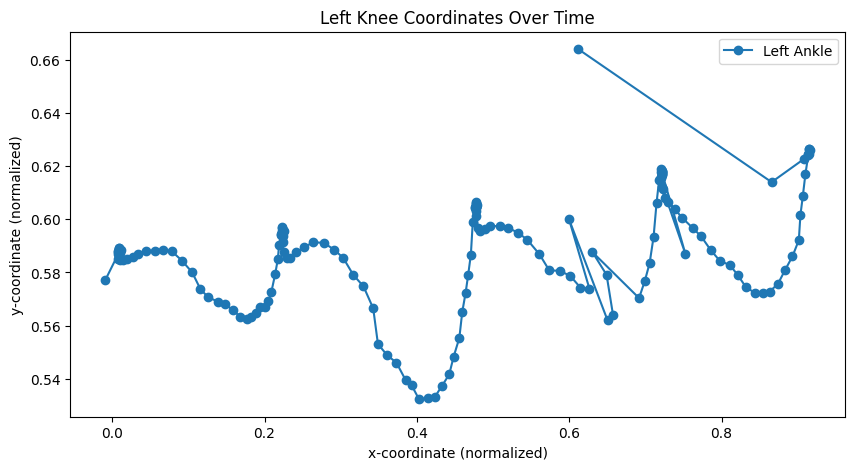

In [53]:
# Plot the coordinates.
plt.figure(figsize=(10, 5))
plt.plot(df['x'], df['y'], 'o-', label='Left Ankle')
plt.xlabel('x-coordinate (normalized)')
plt.ylabel('y-coordinate (normalized)')
plt.title('Left Knee Coordinates Over Time')
plt.legend()
plt.show()

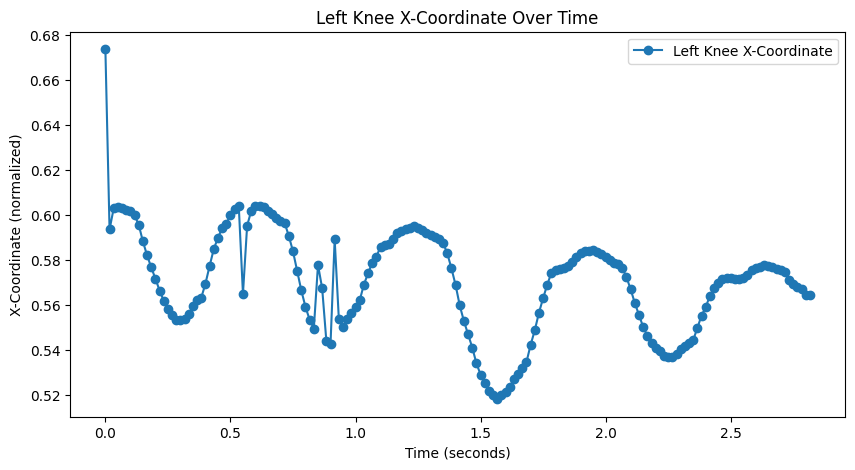

In [79]:
# Plot the coordinates.
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['x'], 'o-', label='Left Knee X-Coordinate')
plt.xlabel('Time (seconds)')
plt.ylabel('X-Coordinate (normalized)')
plt.title('Left Knee X-Coordinate Over Time')
plt.legend()
plt.show()

In [6]:
MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  x_strart = 0
  x_end = -1
  y_start = 0
  y_end = -1
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x-100, bbox.origin_y-100
    end_point = bbox.origin_x + bbox.width+150, bbox.origin_y + bbox.height+200
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    if category.category_name == "person":
      x_strart = bbox.origin_x-100
      x_end = bbox.origin_x + bbox.width+150
      y_start = bbox.origin_y-100
      y_end = bbox.origin_y + bbox.height+200
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    #cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                #FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image[y_start:y_end, x_strart:x_end]

In [7]:
IMAGE_FILE = 'Data\Pictures\photo_2024-02-20_00-12-18.jpg'


img = cv2.imread(IMAGE_FILE)
cv2.imshow("x",img)

# waits for user to press any key 
# (this is necessary to avoid Python kernel form crashing) 
cv2.waitKey(0) 
  
# closing all open windows 
cv2.destroyAllWindows()

In [8]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.vision.core import vision_task_running_mode as running_mode_module
running_mode=running_mode_module.VisionTaskRunningMode.IMAGE
# STEP 2: Create an ObjectDetector object.
with open("efficientdet_lite2.tflite", "rb") as f:
    model_asset_content = f.read()
base_options = mp.tasks.BaseOptions(model_asset_buffer=model_asset_content)
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.15, running_mode=running_mode_module.VisionTaskRunningMode.IMAGE, category_allowlist = ['person'])
detector = vision.ObjectDetector.create_from_options(options)
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2.imshow('output',rgb_annotated_image)
cv2.waitKey(0) 
  
# closing all open windows 
cv2.destroyAllWindows()


cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    # read frame
    _, frame = cap.read()
    try:
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        # STEP 4: Detect objects in the input image.
        detection_result = detector.detect(image)

        # STEP 5: Process the detection result. In this case, visualize it.
        image_copy = np.copy(image.numpy_view())
        annotated_image = visualize(image_copy, detection_result)
        rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        frame = frame#[0:1440,3840-2560:3840]
         #frame = cv2.resize(frame, (1280, 720))
         # convert to RGB
        #frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
         
         # process the frame for pose detection
        pose_results = pose.process(annotated_image)
         # print(pose_results.pose_landmarks)
         
         # draw skeleton on the frame
        mp_drawing.draw_landmarks(annotated_image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        #cv2.imshow('output',cv2.resize(rgb_annotated_image, (1280, 720)))
        cv2.imshow('output',annotated_image)


    except:
         print('hii')
         break
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) #wait until any key is pressed
    
    
          
          
cap.release()
cv2.destroyAllWindows()

hii


In [9]:
from ultralytics import YOLO
import numpy as np

class YOLOSegmentation:
    def init(self, model_path):
        self.model = YOLO(model_path)

    def detect(self, img):
        # Get img shape
        height, width, channels = img.shape

        results = self.model.predict(source=img.copy(), save=False, save_txt=False)
        result = results[0]
        segmentation_contours_idx = []
        bboxes = []
        class_ids = []
        scores = []
        for i, seg in enumerate(result.masks.segments):
            # contours
            seg[:, 0] *= width
            seg[:, 1] *= height
            segment = np.array(seg, dtype=np.int32)
            segmentation_contours_idx.append(segment)

            bbox = np.array(result.boxes.xyxy[i].cpu(), dtype="int")
            bboxes.append(bbox)
            # Get class ids
            class_id = np.array(result.boxes.cls[i].cpu(), dtype="int")
            class_ids.append(class_id)
            # Get scores
            score = np.array(result.boxes.conf[i].cpu(), dtype="float").round(2)
            scores.append(score)

        return bboxes, class_ids, segmentation_contours_idx, scores